# Proyecto Final de carrera: Nuevo modelo para Series de tiempo

## Responsable: <font color='darkred'>**Juan Esteban Serna Vega**</font>  

### Asignación: <font color='navy'>Probar un nuevo modelo sobre los datos del flujo vehicular en una autopista de la Ciudad de Buenos Aires, Argentina. Comparar con la implementación realizada en el Proyecto 03. </font> 

### Github para asignación: https://github.com/jnserna/tsa2.

### Parte A - Resumen de la implementación realizada en el Proyecto 3
<div style="color:#604039; font-style: normal; font-family: Helvetica;">

1. Componentes de la serie<br />
1. Valores atípicos<br />
1. Tratamiento de datos<br />
1. Aplicación inicial de modelos y evaluación de resultados<br />
1. Modelos optimizados<br />
<br />
</div>


### Parte B - Nuevo modelo a explorar
<div style="color:#604039; font-style: normal; font-family: Helvetica;">
Prueba de un nuevo modelo de Machine Learning no visto en la carrera. debes explicar su funcionamiento y por qué consideras apropiado aplicarlo. 


1. Funcionamiento del modelo (explicación)<br />
1. Por qué es apropiado aplicarlo?<br />
1. Implementación del modelo<br />
1. Evaluación de resultados<br />
1. Optimización (acá responder ¿Qué información está usando el modelo para predecir?)<br />
1. Comparación con los demás modelos aplicados<br />
1. Predicción del año 2020<br />
</div>

### Preparación inicial del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa as tsa

from sklearn.model_selection import ParameterGrid
from fbprophet import Prophet

import random

from colorama import Fore
sns.set()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plt.style.use('tableau-colorblind10')

# Lectura de datos
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

data_2020.info()
print()
data_2020.head()

Importing plotly failed. Interactive plots will not work.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB



,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0


Para los años 2017, 2018, 2019 y 2020 se tienen las siguientes columnas con la siguiente información:

- **periodo**: año del dataset 

- **fecha**: año dia mes

- **hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

- **hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

- **dia**: dia de la semana 

- **estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

- **sentido**: Centro o Provincia

- **tipo_vehiculo**: Liviano o Pesado

- **forma_pago**: Hay varias y varian entre los años.

- **cantidad_pasos**: Cantidad de vehiculos

Se trabajará con la estación **Illia** y la forma de pago **Efectivo**

In [2]:
# Unimos los 3 datasets, podemos hacerlo así directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

# Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

# Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
print(dataset.shape)
dataset.head()

(238869, 6)


,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [3]:
# Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

# Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
print(dataset.shape)
dataset.head()

# Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#dataset.head()

# Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

(238869, 5)


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


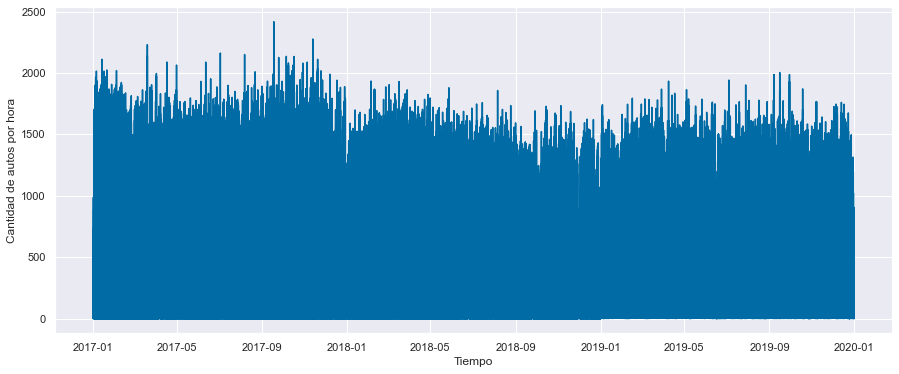

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


In [4]:
# Graficamos los datos tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por hora')
plt.show()
dataset.head()

In [5]:
# Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


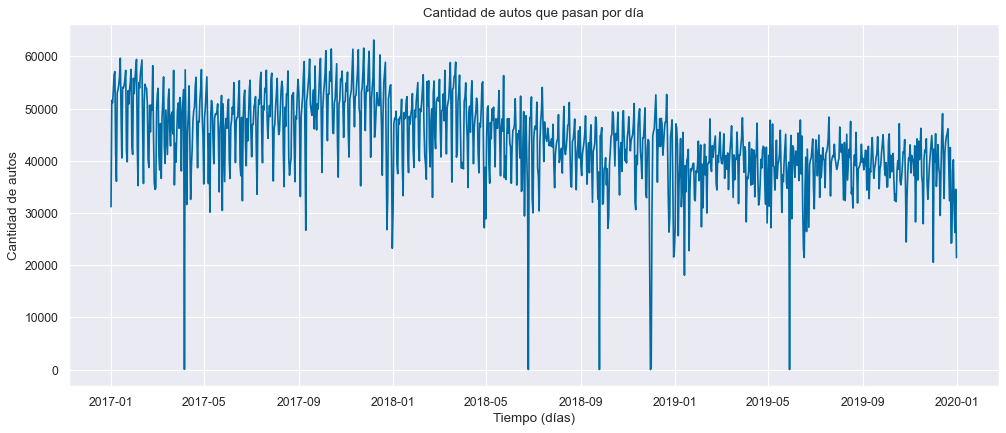

In [6]:
plt.figure(figsize = (15,6), dpi=80)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo (días)')
plt.ylabel('Cantidad de autos')
plt.title("Cantidad de autos que pasan por día")
plt.show()

### Parte A - Resumen* de la implementación realizada (Proyecto 3)

*Esta parte A del presente notebook es un resumen del Proyecto 3, el cual puede ser consultado en detalle [aquí](https://github.com/jnserna/tsa2/blob/main/DS_Proyecto_03_Juan_Serna.ipynb).

**Breve introducción a Series de Tiempo**

¿Qué es una serie de tiempo?
Es un conjunto o serie de observaciones sobre una variable en un horizonte de tiempo. Las observaciones pueden o no ser en intervalos iguales de tiempo.

¿Para qué se estudian las series de tiempo?
El objetivo principal de analizar series de tiempo es conocer el comportamiento de la variable en cuestión. Si se conoce el comportamiento con el paso del tiempo, y bajo el supuesto que no se presentarán cambios fuertes en el futuro, es posible hacer pronósticos. Estas predicciones son valores que se espera tome la variable en un tiempo futuro, y se llega a esos valores utilizando modelos de pronóstico.

Técnicas de predicción en series de tiempo
Hay dos grandes grupos (o formas) de estudiar las series de tiempo.
* Métodos cualitativos: cuando eventos pasados no proporcionan información útil para predecir eventos futuros.
* Métodos cuantitativos: cuando se usa la información de los eventos pasados con el fin de identificar patrones, y con base estos realizar predicciones.

Ahora bien, dentro de los métodos cuantitativos, en los que los datos constituyen la fuente de estudio de patrones de una variable, también hay dos grandes enfoques:
1. Análisis univariante (o individual): se da cuando se trata de explicar una variable a partir de ella misma.
1. Análisis causal: se da cuando se trata de explicar una variable a partir de una o más variables distintitas de ella misma.

El estudio de series de tiempo que popularmente se conoce, trata del primero de estos enfoques. Y es éste mismo el que sustenta el desarrollo teórico del presente análisis.

1. Componentes de una serie de tiempo

Todas las series de tiempo pueden decirse conformadas por componentes. De forma general se consideran:
1. **Tendencia (Trend):** es un patrón de largo plazo caracterizado por la persistencia de crecimiento o decrecimiento de los valores de la serie, 
por tanto refleja el aumento o declinación de la variable de análisis debido a la evolución de factores tecnológicos, demográficos, sociales,
entre otros.
1. **Estacionalidad (Seasonality):** es un patrón de cambio regular que se completa dentro de un período de tiempo específico (casi siempre un año calendario) y que se repite sobre esa base de tiempo.
1. **Error (Error):** son fluctuaciones erráticas alrededor de una constante. No tienen patrón definido. Son afectaciones externas e impredecibles.
1. **Componente cíclica:** se asumen como cambios derivados de fluctuaciones económicas que se dan en períodos largos de tiempo. Por ejemplo: las ventas de propiedad raíz pueden estar afectadas por los ciclos de crecimiento económicos (medidos por el cambio en Producto Interno Bruto -PIB-). Esta componente se incluye en análisis de largos períodos de tiempo.

Partiendo de las componentes mencionadas, se establece que una serie de tiempo *(**Yt**)* es una combinación de sus componentes que puede darse en forma *aditiva* (suma) o *multiplicativa* (multiplicación) de sus componentes.

*Aditiva:* $$Y_t = T_t + S_t + E_t$$ 

*Multiplicativa*: $$Y_t = T_t  \times  S_t \times E_t$$

La formas en que se da esa combinación de las componentes también se denominan métodos de descomposición (o técnicas de agregación), siendo sus métodos más comunes los ya señalados: aditivo y multiplicativo.

### 1. Componentes de la serie
Para generar la descomposición de la serie estudiada en este caso se prefiere el modelo aditivo por dos razones que se identifican en el análisis gráfico:
* La estacionalidad no es creciente
* La serie tiene valores en ceros

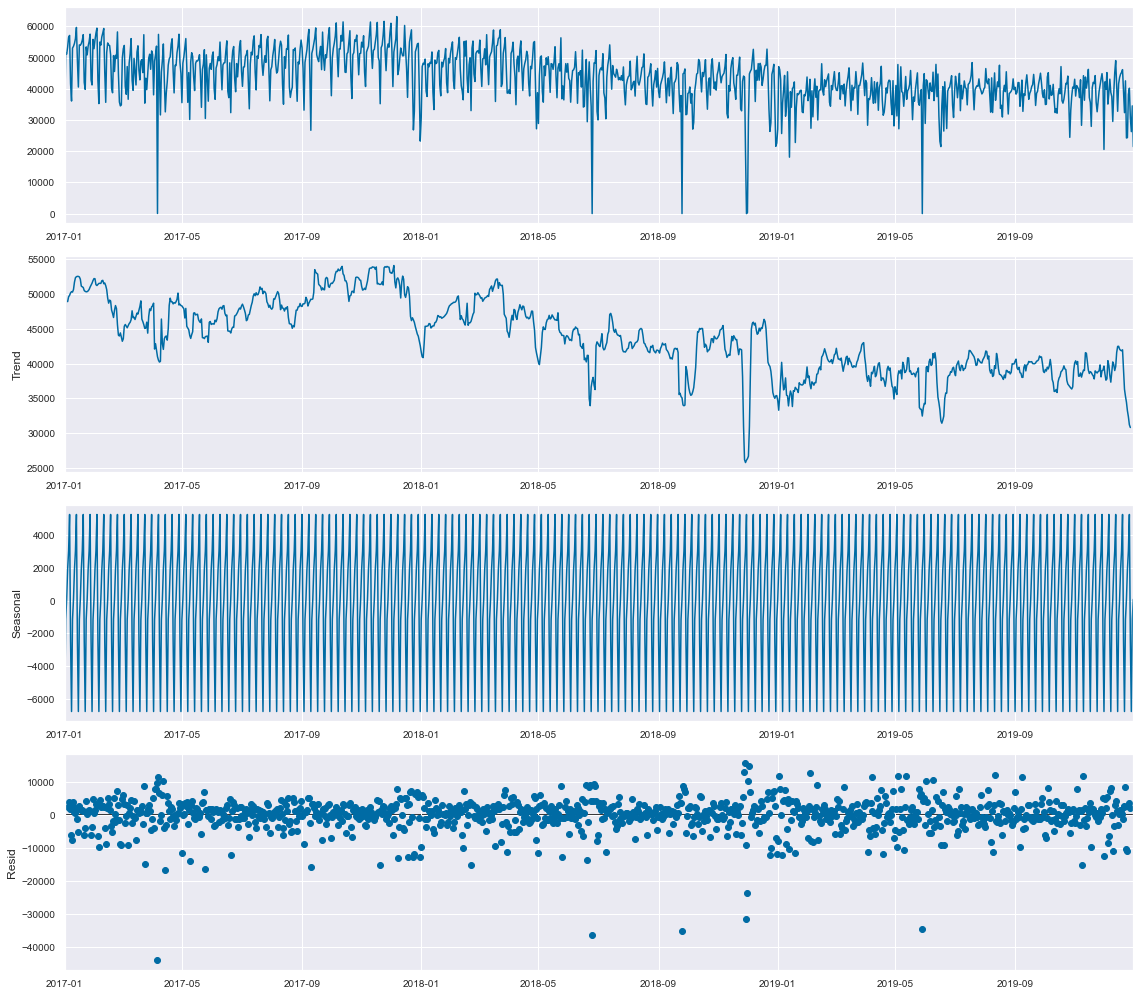

In [7]:
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'

rcParams['figure.figsize'] = 16, 14
series = diario
decomposition = sm.tsa.seasonal_decompose(series, model='additive')
fig = decomposition.plot()
plt.show()

### Tendencia

Cuando esa evolución ocurre de forma altamente predecible, se dice que la tendencia es determinística. Esto es, se puede identificar la
presencia de efectos permanentes sobre la serie de tiempo. Una tendencia determinística suele tener cambios suaves y cierta uniformidad. De forma general, la tendencia determinística se busca modelarla por polinomios de órdenes bajos (hasta grado 3) para mantener la suavidad en el comportamiento. Sin embargo, hay casos donde la tendencia queda mejor modelada por funciones como la exponencial.

Por el contrario, si la evolución es difícil de predecir, se dice que la tendencia es estocástica. En series de este tipo la tendencia es impulsada por choques estocásticos y no siempre presenta un nivel particular hacia el cual tienda a regresar; la serie se mueve hacia donde la obliguen los choques recibidos. Esta tendencia se modela generalmente por caminata aleatoria.

Para el caso de los pasos por la autopista, observando los datos 2017 - 2019 se observa una tendencia general determinística, la cual tiende a la baja desde finales de 2017 y a una estabilización hacia finales de 2019.

### Estacionalidad

Como ya se mencionó, la estacionalidad es un patrón de cambio regular en un período de tiempo específico (casi siempre un año calendario) y que se repite sobre esa base de tiempo. Este comportamiento se da generalmente por factores repetitivos como estaciones (clima) y consumos que ocurren en períodos particulares, etc. Es decir, eventos que se dan con una periodicidad definida (semanales, mensuales, trimestrales, semestrales, anuales). Por ejemplo, las ventas de productos como helados, bebidas, prendas de vestuario, juguetes, etc. suele estar sujetas a este tipo de patrones.

Al igual que la tendencia, la estacionalidad también puede ser determinística o estocástica. La estacionalidad se puede modelar por regresión o por funciones trigonométricas.

Para la variable de pasos por la autopista, luego de observar la serie global, y también de analizar algunos tramos (años) se identifica un patrón estacional semanal que no cambia en varianza. Esto es, la dimensión (vista gráficamente) del patrón estacional se mantiene igual con el paso del tiempo. Si hubiera presencia de varianza, esto es si la estacionalidad fuera creciente o más pronunciada, se buscaría linealizar un poco la tendencia, por ejemplo con tranformación logarítmica. Dado que la serie presenta varianza constante, es posible decir, por lo menos de forma preliminar, que cumple uno de los supuestos para ser estacionaria.

### Error

Gráficamente se observa que los residuales no presentan un patrón definido y siempre están alrededor de una media. En este caso, la media es cero. Pero no siempre lo es.

A manera de **conclusión** se puede decir que la serie analizada presenta una tendencia general determinística, la cual tiende a la baja desde finales de 2017 y a una estabilización hacia finales de 2019. Adicional se observa un patrón estacional semanal y es de componentes aditivas.

### Conceptos adicionales

**Estacionariedad**: que una serie de tiempo sea estacionaria significa que sus propiedades estadísticas no cambian con el tiempo. Para concluir con mayor certeza que una serie de tiempo es estacionaria se debería identificar que:

1. La media es constante en el tiempo (no tiene tendencia)
1. La varianza es constante en el tiempo
1. La estructura de autocovianza es constante en el tiempo

**Supuesto de normalidad**
* Los errores siguen una distribución normal (distribución gaussiana o distribución de Laplace-Gauss) y su media es cero* 
* Varianza constante (homocedasticidad)


Los conceptos anteriores permiten utilizar un modelo de regresión para el ajuste de series de tiempo, dado que se asume que las relaciones establecidas por en la serie son estables a lo largo del tiempo, esto es, que los parámetros del modelo no cambian. Sin embargo, en la vida real las relaciones comerciales, industriales y económicas pueden variar con el paso del tiempo, por lo que es necesario evaluar e identificar los parámetros del modelo que son variables en el tiempo, en particular cuando hay componente estacional, ya que esta puede no ser constante.

### 2. Valores atípicos

In [8]:
print(dataset.isnull().sum(),'\n')
print(color.GREEN + 'El dataset no presenta valores faltantes.' + color.END,'\n')
print('Sin embargo, gráficamente se observó que hay días con valores muy bajos de tránsito.')
print('Ver gráfica Cantidad de autos que pasan por día.','\n')
print('Esos días y sus valores de tráfico son:','\n')
diario_a=diario[diario.cantidad_pasos <=15000]
diario_a

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64 

El dataset no presenta valores faltantes. 

Sin embargo, gráficamente se observó que hay días con valores muy bajos de tránsito.
Ver gráfica Cantidad de autos que pasan por día. 

Esos días y sus valores de tráfico son: 



,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Posibles explicaciones de los valores atípicos

Los valores atípicos de baja cantidad de vehículos transitando en días específicos pueden ser explicados a partir de situaciones anormales. A continuación se comentan algunos casos que pudieron incidir en la situación de tráfico para cada día.
* 2017-04-06: La primera huelga general contra el Presidente Macri. *Fuente: RTVE.*
[Ver más](https://www.rtve.es/noticias/20170406/argentina-afronta-este-jueves-primera-huelga-general-contra-gobierno-macri/1518360.shtml).

* 2018-06-25: Paro general en Argentina. *Fuente: TelesurTV.*
[Ver más](https://www.telesurtv.net/news/tercer-paro-argentina-macri--20180625-0009.html).

* 2018-09-25: Protestas y movilizaciones en rechazo a políticas económicas del Presidente Macri. *Fuente: France24.*
[Ver más](https://www.france24.com/es/20180925-argentina-protestas-macri-huelga-general).

* 2018-11-30: Movilizaciones y protestas en el marco de la cumbre del G-20. *Fuente: Forbes México.*
[Ver más](https://www.forbes.com.mx/cumbre-del-g20-inicia-en-medio-de-protestas-y-fuerte-seguridad/).

* 2018-12-01: Protestas contra modificaciones al sistema pensional. *Fuente: France24.*
[Ver más](https://www.france24.com/es/20171219-protestas-argentina-reforma-violencia-pensiones).

* 2019-02-29: Huelga general. *Fuente: DW.*
[Ver más](https://www.dw.com/es/argentina-gobierno-enfrenta-una-nueva-huelga-general/a-48973717).

### 3. Tratamiento de datos

Para el caso de estudio se aplicarán dos tratamientos de datos sobre el dataset. A saber: tratamiento de **outliers** y **resampleo**.

- Tratamiento de outliers

Dado que los datos vistos por día presentan valores en ceros y algunos días con cifras muy bajas de tránsito, es de esperar que los modelos de pronóstico reduzcan su buen desempeño cuando se presentan estos valores atípicos dentro de los datos originales. Adicional, como principio de los pronósticos se espera que se cumpla el supuesto de continuidad, que asume que algunos patrones dados en el pasado continuarán en el futuro.

Por tales razones se decide tratar esos outliers y asignarles valores. Es difícil predecir externalidades que suspendan por completo el tráfico en la autopista (huelgas, paros o eventos catastróficos). Por lo tanto es preferible asumir continuidad en el tráfico por días de la autopista.

Cuando se va a implementar una interpolación, es necesario tener claridad si los datos de la serie son igualmente espaciados o no. Adicional, es importante saber que hay diversos métodos (globales o locales) y criterios o técnicas de interpolación (movimiento o puente Browniano, suavizado Kernel, vecinos más cercanos, entre otros.). Atendiendo al problema de este dataset, que refiere a tránsito de vehículos por una autopista, se decide tratar los ouliers con la técnica de vecinos más cercanos. Como consideración adicional para el tratamiento, se destaca que solo se modifican los datos de seis días de una muestra de tres años de registros.

Cantidad de datos que van a ser reemplazados:
cantidad_pasos    6
dtype: int64 

Verificación de datos pendientes por reemplazar:
cantidad_pasos    0
dtype: int64 

Luego el dataset gráficamente (sin outliers) se ve de esta manera: 



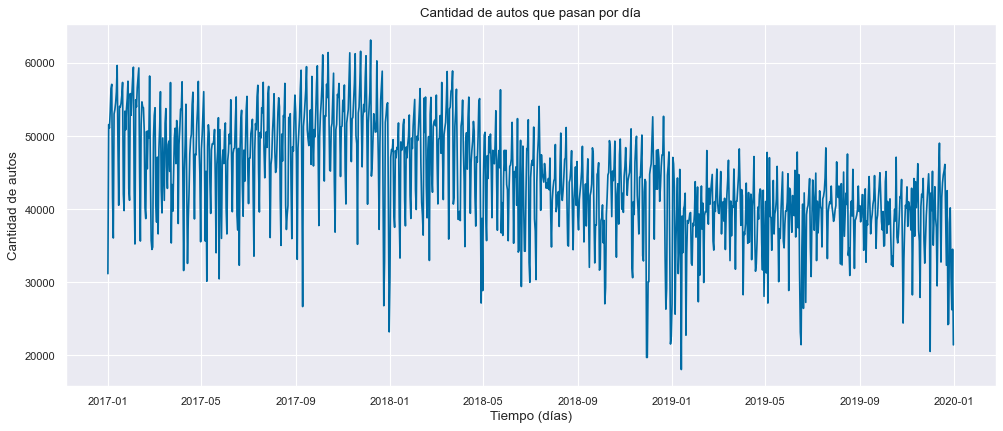

In [9]:
#Los datos atípicos se reemplazan por nan
print('Cantidad de datos que van a ser reemplazados:')
diario.cantidad_pasos[diario.cantidad_pasos <=15000] = np.nan

# Se imprimen para verificar valores
print(diario.isna().sum(),'\n')

# Se indica el criterio para interpolar
diario = diario.interpolate(method='nearest', k=4)

# Se verifica el cambio
print('Verificación de datos pendientes por reemplazar:')
print(diario.isna().sum(),'\n')
print('Luego el dataset gráficamente (sin outliers) se ve de esta manera:','\n')

plt.figure(figsize = (15,6), dpi=80)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo (días)')
plt.ylabel('Cantidad de autos')
plt.title("Cantidad de autos que pasan por día")
plt.show()

- Resampleo

Esta transformación (también llamada remuestreo), al igual que casi todas las realizadas sobre los dataset, se realiza para mejorar la predictibilidad de los datos. El resampleo de series puede darse en dos formas:
1. Aumentando la frecuencia de los datos (upsampling)
2. Reduciendo la frecuencia de los datos (downsampilng)

Para este caso, se hace un ***downsampling*** de días a semanas. Este resampleo reduce incertidumbre y complejidad para los pronósticos dado que no exige el uso de patrones diarios. Como se observó en el decompose, en la vista por semanas ya se identifica estacionalidad. Adicional, es posible hacerlo dado que el resultado final de la predicción del modelo no obliga a ser presentado por días.

El resampleo de días a semanas puede generarse en forma de suma o en forma de promedio. La diferencia se genera en el peso que se le da a los días al considerar el promedio, y en la escala que se genera si se trabaja con la acumulación de datos o con el promedio. Lo importante de seleccionar sum o mean es que no se pierdan o se alteren significativamente los patrones de la serie. Las siguientes dos ejecuciones permiten verificar gráficamente que los patrones de los datos no se alteran.

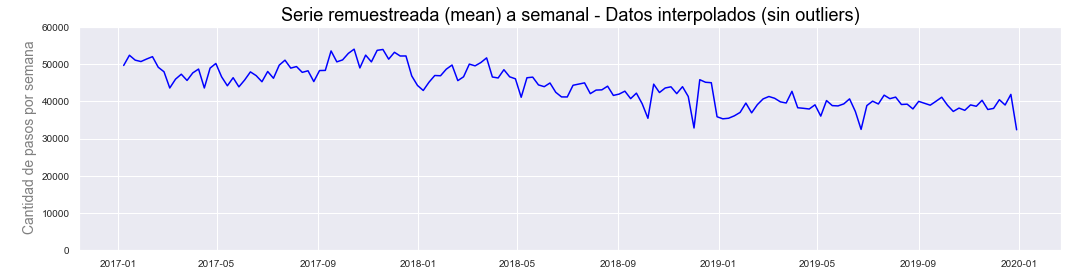

In [10]:
# Transformación a semanal por sumas (a la base sin ceros y sin outliers)
semanal = diario.resample('W').sum()

# Se quitan unos datos de semanas que están incompletas
semanal = semanal[(semanal.index >='2017-01-08')&(semanal.index <='2019-12-29')]

# Transformación a semanal por medias (a la base sin ceros y sin outliers)
semanal_m = diario.resample('W').mean()

# Se quitan unos datos de semanas que están incompletas
semanal_m = semanal_m[(semanal_m.index >='2017-01-08')&(semanal_m.index <='2019-12-29')]

plt.figure(figsize = (15,4))
plt.plot(semanal_m.index, semanal_m.cantidad_pasos,color='blue')
plt.title("Serie remuestreada (mean) a semanal - Datos interpolados (sin outliers)", color= 'black', fontsize= 18)
plt.ylabel('\n Cantidad de pasos por semana', color= 'gray', fontsize= 14)
plt.ylim(0,60000)
plt.tight_layout()
plt.show()

Decompose de la serie utilizada para el ajuste de modelos

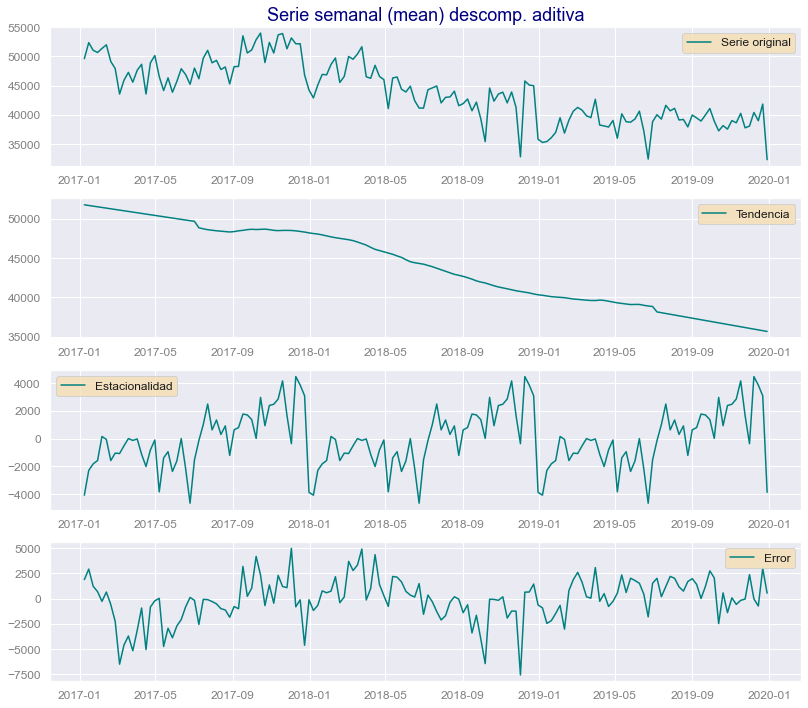

In [11]:
# Descomposicón aditiva
result_mean = tsa.seasonal.seasonal_decompose(semanal_m.cantidad_pasos, model='additive', extrapolate_trend='freq')

plt.figure(figsize = (22,10))
Gs= gridspec.GridSpec(4,2)

ax1= plt.subplot(Gs[1])
plt.plot(semanal_m, color='teal', label="Serie original")
plt.legend(fontsize=12, facecolor= 'wheat')
plt.title("Serie semanal (mean) descomp. aditiva", color= 'navy', fontsize= 18)
plt.xticks( color= 'grey', fontsize= 12)
plt.yticks( color= 'grey', fontsize= 12)

ax3= plt.subplot(Gs[3])
plt.plot(result_mean.trend,color='teal', label="Tendencia")
plt.legend(fontsize=12, facecolor= 'wheat')
plt.xticks( color= 'grey', fontsize= 12)
plt.yticks( color= 'grey', fontsize= 12)

ax5= plt.subplot(Gs[5])
plt.plot(result_mean.seasonal,color='teal', label='Estacionalidad')
plt.legend(fontsize=12, facecolor= 'wheat')
plt.xticks( color= 'grey', fontsize= 12)
plt.yticks( color= 'grey', fontsize= 12)

ax7= plt.subplot(Gs[7])
plt.plot(result_mean.resid,color='teal', label='Error')
plt.legend(fontsize=12, facecolor= 'wheat', loc= 1)
plt.xticks( color= 'grey', fontsize= 12)
plt.yticks( color= 'grey', fontsize= 12)

plt.tight_layout()
plt.show()

### 4. Aplicación inicial de modelos y evaluación de resultados

2. Modelos seleccionados:
- Modelo 1: Random Forest Regressor
- Modelo 2: SARIMAX

Modelo 1: **Random Forest**

Random Forest está integrado por un *ensemble* o conjunto de árboles de decisión, donde cada árbol ha sido entrenado con una muestra aleatoria de los datos de entrenamiento originales generada a través de *Bootstrapping*. La predicción de una nueva observación proviene de la agregación de los pronósticos obtenidos de los árboles individuales que integran el modelo.

Las razones para usar este modelo tienen que ver con sus ventajas generales de aplicaciones, que incluyen: selección automática de predictores, y la posibilidad de usarlo con un número grande de datos.

Modelo 2: **SARIMAX**

Algunos conceptos que pueden ser de utilidad para entender este modelo:
- SARIMAX (promedio móvil integrado autoregresivo estacional con factores exógenos) es en el fondo un modelo de regresión lineal que utiliza un modelo ARIMA estacional de residuos.

- ARIMA: media móvil integrada autoregresiva. Proviene de la integración (I) de modelos autoregresivos (AR) con medias móviles (MA).

- Modelos autoregresivos (AR): son aquellos que predicen la siguiente observación basados en observaciones anteriores. Esto es similar a una regresión lineal. La cantidad de puntos anteiores se denomina orden (p).

Para que los ajustes funcionen bien bajo esta metodología, es necesario que los datos cumplan la condición de **estacionariedad**.

Dentro de las motivaciones para usar el modelo SARIMAX se considera lo bien que trabaja con datos estacionales, contrario a lo que pasa sólo con ARIMA.

SARIMAX entonces requiere dos conjuntos de argumentos (p,d,q). Uno que es el mismo que requiere ARIMA, y otro para la estacionalidad.
* p: número de observaciones hacia atrás que considera el modelo para el pronóstico.
* d: número de diferencias entre las observaciones originales.
* q: orden del promedio móvil.

Adicional requiere un argumento S que es la periodicidad del ciclo estacional de los datos. Para datos con estacionalidad anual, S será 12. Para datos con estacionalidad semanal, S será 7.

$$SARIMAX\left(p,d,q\right) x \left(p,d,q,s\right)$$

A continuación el desarollo de ambos modelos y su evaluación.

In [12]:
# Preparación de datos

# Semanal Medias
semanal=semanal_m[(semanal_m.index >='2017-01-08')&(semanal_m.index <='2019-12-29')]
senial = semanal.cantidad_pasos

# Valores para atrás que se tomarán
look_back = 12

N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(143, 12) (143,)


In [13]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

# train test split
N_train = X.shape[0] - look_back # cantidad de puntos que se van a usar para entrenar 
N_test = 12  # cantidad de puntos que se van a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(131, 12) (131,)
(12, 12) (12,)


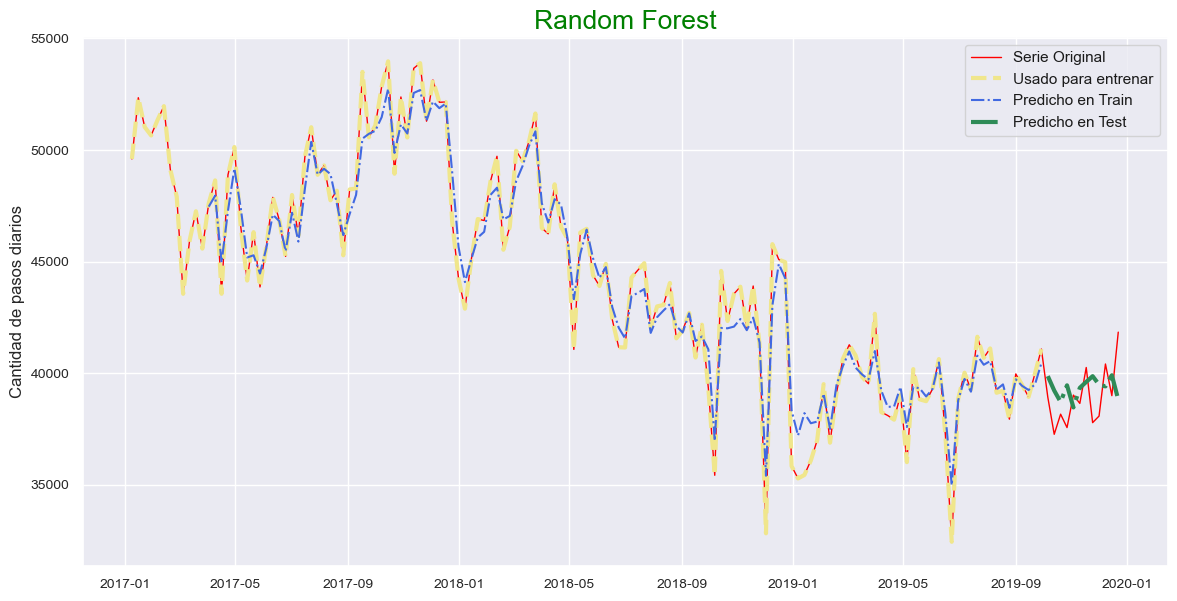

RMSE en Train: 1036.71
RMSE en Test: 1503.443 



In [17]:
# Random forest
rf = RandomForestRegressor(random_state=123, n_jobs = -1)

rf.fit(X_train,y_train)
x = rf.fit(X_train,y_train)

y_train_pred_rf1 = rf.predict(X_train)
y_test_pred_rf1 = rf.predict(X_test)

# Gráfica
plt.figure(figsize = (14,7), dpi=100)
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='khaki',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_rf1,'-.',color='royalblue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_rf1,'-.',color='seagreen', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.title("Random Forest", color= 'green', fontsize= 19)
plt.ylabel('Cantidad de pasos diarios')
plt.show()

rmse_tr_1 = np.sqrt(mean_squared_error(y_train, y_train_pred_rf1))
print('RMSE en Train:',round(rmse_tr_1,3))

rmse_ts_1 = np.sqrt(mean_squared_error(y_test, y_test_pred_rf1))
print('RMSE en Test:',round(rmse_ts_1,3),"\n")

* Modelo 2: SARIMAX

Inicialmente se trabaja el modelo con parámetros p, d y q de órdenes bajos (complejidad baja). El valor de s se asigna 7 por la condición de estacionalidad semanal de los datos.

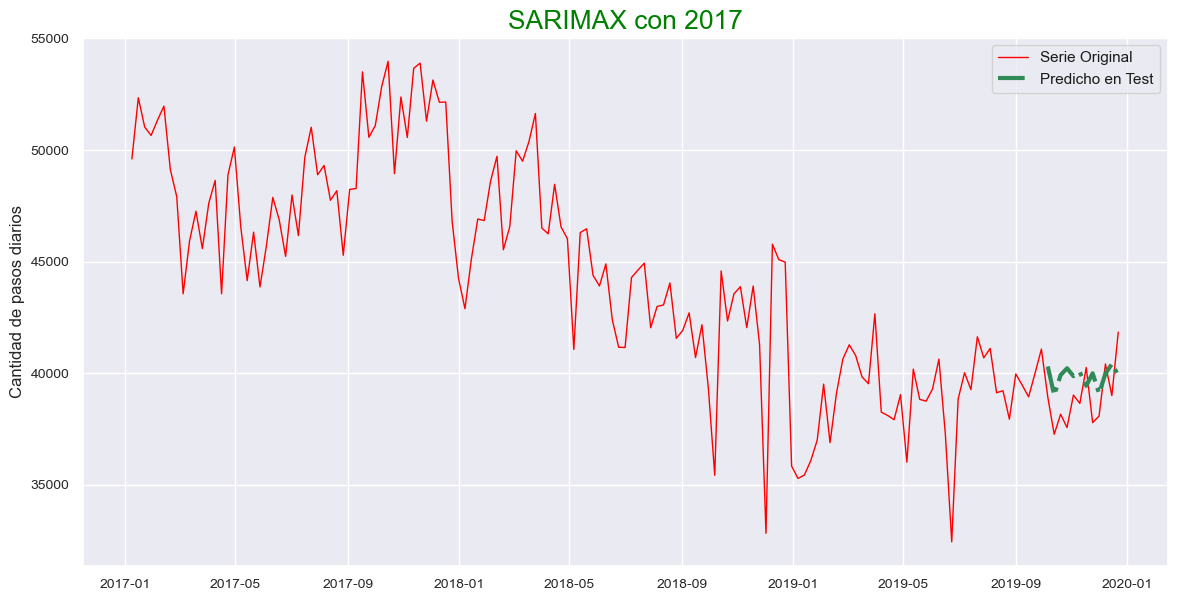

RMSE en Test con 2017: 1588.402
AIC: 2604.417 



In [18]:
# Definir conjunto de datos
x = senial[:N_train + look_back]

# instanciar modelo
sarima_model = SARIMAX(x, order=(2,0,1), seasonal_order=(2, 1, 0, 7))

# ajustar modelo
results = sarima_model.fit()

# predecir
forecast = results.get_forecast(steps=12).predicted_mean

# Gráfica
plt.figure(figsize = (14,7), dpi=100)
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], forecast,'-.',color='seagreen', lw = 3, label = 'Predicho en Test')
plt.title("SARIMAX con 2017", color= 'green', fontsize=19)
plt.ylabel('Cantidad de pasos diarios')
plt.legend()
plt.show()

y_test_pred_sx1 = forecast

rmse_ts_sx1 = np.sqrt(mean_squared_error(y_test, y_test_pred_sx1))
print('RMSE en Test con 2017:',round(rmse_ts_sx1,3))
print('AIC: ' + str(round(results.aic,3)),'\n')

3. Modelo benchmark: Medias Móviles (orden 2)

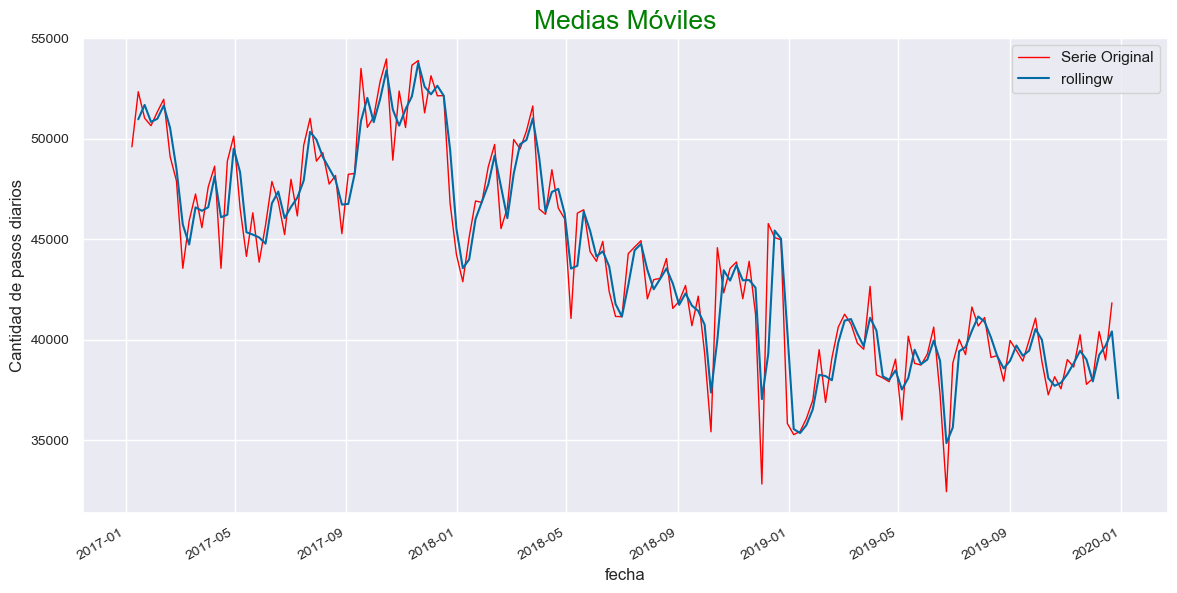

RMSE en Test: 1586.038


In [19]:
semanal['rollingw'] = semanal['cantidad_pasos'].rolling(2).mean()

plt.figure(figsize = (14,7), dpi=100)
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
semanal['rollingw'].plot()
plt.title("Medias Móviles", color= 'green', fontsize= 19)
plt.ylabel('Cantidad de pasos diarios')
plt.legend()
plt.show()

y_test_mod3 = semanal['rollingw'].tail(12)

rmse_ts_3 = np.sqrt(mean_squared_error(y_test, y_test_mod3))
print('RMSE en Test:',round(rmse_ts_3,3))

## Evaluación de los modelos de pronóstico

El principal criterio utilizado para la evaluación de los modelos es el RMSE. Su cálculo consiste en la raíz cuadrada de la sumatoria de los errores cuadráticos. RMSE expande y castiga con mayor fuerza aquellos errores de mayor magnitud. La fórmula de cálculo del RMSE se muestra a continuación:

$$RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(y_{i} - x_{i})^{2}}$$

donde $$y_{i}: Predicción$$
$$x_{i}: Valor\thinspace actual$$

Para la evaluación de los ajustes con SARIMAX se considera también el AIC como criterio de evaluación. AIC es una medida de calidad de pronósticos que hace un balance entre complejidad del modelo y bondad de ajuste.

In [20]:
result1= {'Modelo':['Rolling W (Benchmark)','Random Forest','SARIMAX'],
          'RMSE Test':[rmse_ts_3,rmse_ts_1,rmse_ts_sx1]}
tabla=pd.DataFrame(result1)
tabla

,Modelo,RMSE Test
0,Rolling W (Benchmark),1586.038257
1,Random Forest,1503.443101
2,SARIMAX,1588.401779


5. Modelos optimizados

* Optimización Modelo 1: Random Forest

Valor óptimo de n_estimators por r2: 175 

Valor óptimo de n_estimators por RMSE: 175 



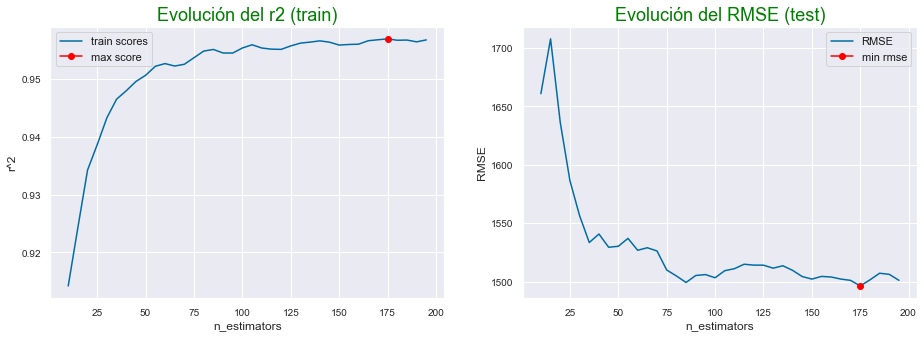

In [21]:
train_scores = []
rmse_score   = []

# Rango de valores evaluados
estimator_range = range(10, 200, 5)

# Ciclo para entrenar un modelo con cada valor de n_estimators y extraer su error de ajuste (entrenamiento)
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    y_test_modelo = modelo.predict(X_test)
    train_scores.append(modelo.score(X_train, y_train))
    rmse_score.append(np.sqrt(mean_squared_error(y_test, y_test_modelo)))

# Gráficos con la evolución de los errores
plt.figure(figsize = (24,5))
plt.subplot(1,3,1)
plt.plot(estimator_range, train_scores, label="train scores")
plt.plot(estimator_range[np.argmax(train_scores)], max(train_scores), marker='o', color = "red", label="max score")
plt.ylabel("r^2")
plt.xlabel("n_estimators")
plt.title("Evolución del r2 (train)",color= 'green', fontsize= 18)
plt.legend();
print(f"Valor óptimo de n_estimators por r2: {estimator_range[np.argmax(train_scores)]}","\n")

plt.subplot(1,3,2)
plt.plot(estimator_range, rmse_score, label="RMSE")
plt.plot(estimator_range[np.argmin(rmse_score)], min(rmse_score), marker='o', color = "red", label="min rmse")
plt.ylabel("RMSE")
plt.xlabel("n_estimators")
plt.title("Evolución del RMSE (test)",color= 'green', fontsize= 18)
plt.legend();
print(f"Valor óptimo de n_estimators por RMSE: {estimator_range[np.argmin(rmse_score)]}","\n")

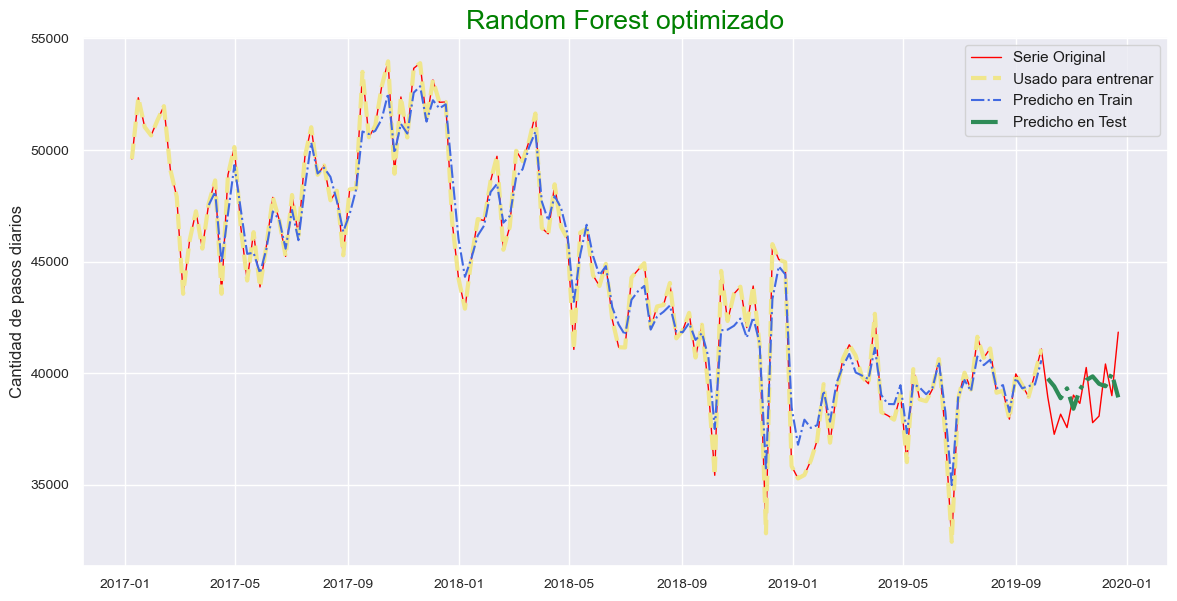

RMSE en Train: 1018.217
RMSE en Test: 1496.436 



In [22]:
# Modelo Random Forest Optimizado
n_estimators = 175
rf = RandomForestRegressor(n_estimators = n_estimators, random_state=123, n_jobs = -1)

rf.fit(X_train,y_train)
x = rf.fit(X_train,y_train)

y_train_pred_rf1 = rf.predict(X_train)
y_test_pred_rf1 = rf.predict(X_test)

# Gráfica
plt.figure(figsize = (14,7), dpi=100)
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='khaki',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_rf1,'-.',color='royalblue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_rf1,'-.',color='seagreen', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.title("Random Forest optimizado", color= 'green', fontsize= 19)
plt.ylabel('Cantidad de pasos diarios')
plt.show()

rmse_tr_1 = np.sqrt(mean_squared_error(y_train, y_train_pred_rf1))
print('RMSE en Train:',round(rmse_tr_1,3))

rmse_ts_1 = np.sqrt(mean_squared_error(y_test, y_test_pred_rf1))
print('RMSE en Test:',round(rmse_ts_1,3),'\n')

### Parte B - Nuevo modelo a explorar: Prophet

Prophet es una librería de código abierto desarrollada por Facebook para el estudio de series de tiempo univariadas. Su principal utilidad es la predicción de series de tiempo, y en su concepción se priorizó la automatización al máximo nivel de los procesos de pronóstico, y la facilidad para que la herramienta fuera usada por usuarios sin amplia experiencia en Estadística.
[Ampliar info.](https://research.fb.com/prophet-forecasting-at-scale/)

1. Funcionamiento del modelo

Prophet es un modelo de regresión aditiva con una tendencia de curva de crecimiento lineal o logística por partes. Incluye un componente estacional anual modelado usando series de Fourier y una componente estacional que reconoce patrones semanales, diarios o anuales.

Prophet entrega un modelo encontrando la mejor línea que se puede representar la serie como una suma de estas componentes:

$$Y(t) = g(t) + s(t) + h(t) + E(t)$$ 

donde $$g(t): Tendencia\thinspace de\thinspace crecimiento\thinspace general$$
$$s(t): Estacionalidad$$
$$h(t): Efecto\thinspace de\thinspace los\thinspace feriados$$

2. Por qué es apropiado aplicarlo?

Prophet es una herramienta particularmente útil para conjuntos de datos con las siguientes condiciones (entre otras):
- Estacionalidades marcadas
- Datos atípicos (o vacíos)
- Tendencias de crecimiento no lineal
- Observaciones detalladas (por hora, día o semana) de tiempos extendidos (meses o años).<br />
[Ver en más detalle.](https://docs.aws.amazon.com/es_es/forecast/latest/dg/aws-forecast-recipe-prophet.html)

Dado que el dataset cumple las condiciones anteriormente comentadas, es pertinente explorar la aplicación de este modelo.

Referencias

3. Implementación del modelo

In [23]:
# Preparación de los datos

semanal=semanal_m[(semanal_m.index >='2017-01-08')&(semanal_m.index <='2019-12-29')]
senial = semanal.cantidad_pasos

look_back = 7 # usamos una semana de datos para predecir el valor siguiente

N = senial.shape[0]

X = np.zeros((N - look_back,look_back))#((N - look_back - 1,look_back))
y = np.zeros(N - look_back)#(N - look_back - 1)

print(X.shape, y.shape)

(149, 7) (149,)


In [24]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

N_train = 52*2 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 52*1 #cantidad de puntos que vamos a usar para evaluar

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(97, 7) (97,)
(52, 7) (52,)


In [25]:
# Implementación del modelo

DS_prophet = pd.DataFrame()

DS_prophet["ds"] = pd.to_datetime(senial.index)
DS_prophet["y"] = senial.values

end_date = '2019-09-30'
mask1 = (DS_prophet['ds'] <= end_date)
mask2 = (DS_prophet['ds'] > end_date)

X_train = DS_prophet.loc[mask1]
X_test = DS_prophet.loc[mask2]
print("train shape",X_train.shape)
print("test shape",X_test.shape)

train shape (143, 2)
test shape (13, 2)


In [26]:
prophet_model = Prophet()
prophet_model.fit(X_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# Predicción
future = prophet_model.make_future_dataframe(periods=12)
forecast = prophet_model.predict(future)

# Se agrega al dataset el valor de la predicción
DS_prophet['yhat'] = forecast['yhat']

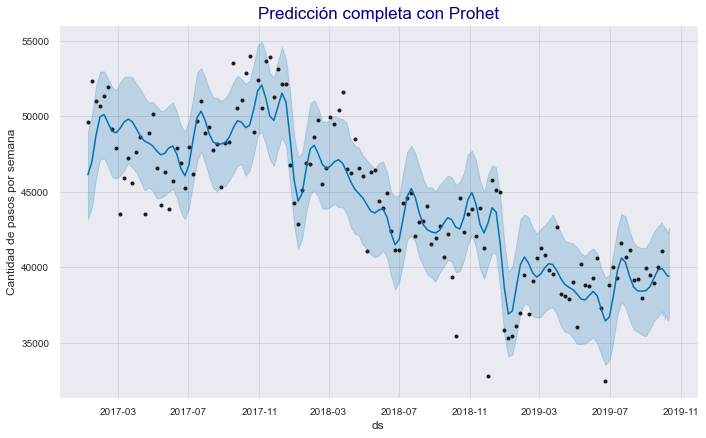

In [34]:
fig1 = prophet_model.plot(forecast,ylabel='Cantidad de pasos por semana')
plt.title("Predicción completa con Prohet", color= 'navy', fontsize= 17);

4. Evaluación de resultados del modelo

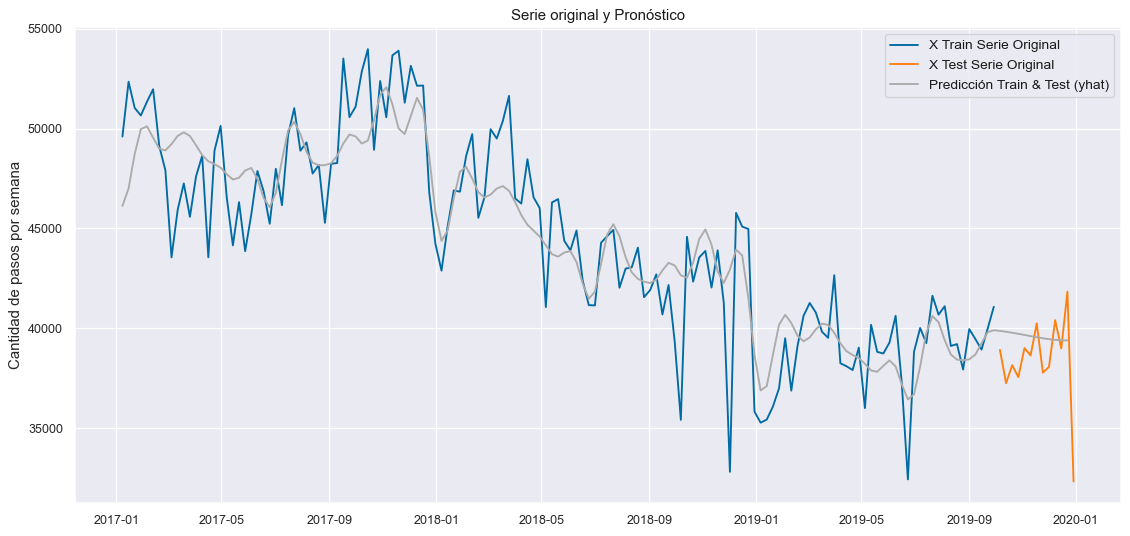

RMSE en Train: 2414.0
RMSE en Test: 1403.0


In [29]:
plt.figure(figsize = (15,7), dpi=90)
plt.plot(X_train['ds'], X_train['y'])
plt.plot(X_test['ds'], X_test['y'])
plt.plot(DS_prophet['ds'], DS_prophet['yhat'])
plt.title('Serie original y Pronóstico')
plt.legend(['X Train Serie Original','X Test Serie Original ','Predicción Train & Test (yhat)'])
plt.ylabel('Cantidad de pasos por semana')
plt.show()

# Evaluación del modelo
msk_pred_train = (forecast['ds']<= '2019-09-30')
msk_pred_test = (forecast['ds']> '2019-09-30')
pred_train = (forecast[msk_pred_train])
pred_test = (forecast[msk_pred_test])

y_pred_train = pred_train['yhat'][1:]
y_pred_test = pred_test['yhat']

rmse_pred_train = np.sqrt(mean_squared_error(X_train['y'], y_pred_train))
print(f'RMSE en Train: {round(rmse_pred_train,0)}')

rmse_pred_test = np.sqrt(mean_squared_error(X_test['y'][:-2], y_pred_test))
print(f'RMSE en Test: {round(rmse_pred_test,0)}')

5. Optimización

Usando un rango de 0.1 a 0.6 para las variables del modelo, se requiere evaluar 6**3 posibles modelos que son producto de las combinaciones entre los posibles valores de estas variables.

In [30]:
tabla_parametros = {'seasonality_mode':['additive'],
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5,0.6],
               'seasonality_prior_scale': [0.1,0.2,0.3,0.4,0.5,0.6],
               'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5,0.6]
              }
grid = ParameterGrid(tabla_parametros)
modelos_posibles = 0
for p in grid:
    modelos_posibles = modelos_posibles+1

print('Cantidad de modelos posibles: ',modelos_posibles, '\n')

Cantidad de modelos posibles:  216 



A continuación se presentan los RMSE para diferentes modelos posibles a partir de las combinaciones de valores.

In [41]:
strt='2019-10-01'
end='2019-12-31'

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])

for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(seasonality_mode = p['seasonality_mode'],
                         changepoint_prior_scale = p['changepoint_prior_scale'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         weekly_seasonality=True,
                         daily_seasonality = False,
                         yearly_seasonality = True)
    train_model.add_country_holidays(country_name='AR')
    train_model.fit(X_train)
    train_forecast = train_model.make_future_dataframe(periods=13, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = DS_prophet[(DS_prophet['ds']>=strt) & (DS_prophet['ds']<=end)]
    #EL puntaje RMSE se calcula en X_test
    RMSE = round(np.sqrt(mean_squared_error(Actual['y'],abs(test['yhat']))),3)
    print('RMSE --> ',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}
RMSE -->  2960.04
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2}
RMSE -->  2958.494
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3}
RMSE -->  2953.8
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.4}
RMSE -->  2959.999
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
RMSE -->  2979.276
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.6}
RMSE -->  2915.488
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}
RMSE --

Resumen de las iteraciones

In [42]:
param_opt = model_parameters.sort_values(by=['RMSE'])
param_opt = param_opt.reset_index(drop=True)
param_opt.head()

,RMSE,Parameters
0,2086.444,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
1,2086.450,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
2,2087.463,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
3,2088.518,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
4,2088.575,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


In [43]:
print('Parámetros que hacen mínimo el RMSE:')
param_opt['Parameters'][0]

Parámetros que hacen mínimo el RMSE:


{'changepoint_prior_scale': 0.3,
 'holidays_prior_scale': 0.3,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.4}

6. Comparación con los demás modelos aplicados

La facilidad para su aplicación y su uso es una de las grandes ventajas de este modelo. Es muy intuitivo y sencillo de usar por parte de personas sin conocimientos avanzandos de Series de tiempo. Esto sin lugar a dudas es una ganancia del modelo. Sin embargo, entender exactamente los cálculos que realiza Prophet demanda conocimientos avanazados en Matemáticas y Estadística, que permiten conocer a fondo series de Fourier y aplicaciones de Regresión Logística.

Por otra parte, se encuentra que el modelo ajustado inicialmente tiene un desempeño (en términos de RMSE) un poco mejor que SARIMAX y que RF. No obstante, al intentar llevar el Prophet a un nivel mayor de desempeño, se encuentra que el rango de valores evaluado para los parámetros no mejora el desempeño del modelo.

7. Predicción del año 2020

Para la elaboración del pronóstico para el año 2020 se toman los parámetros que entregan el menor RMSE de la evaluación previamente ejecutada.

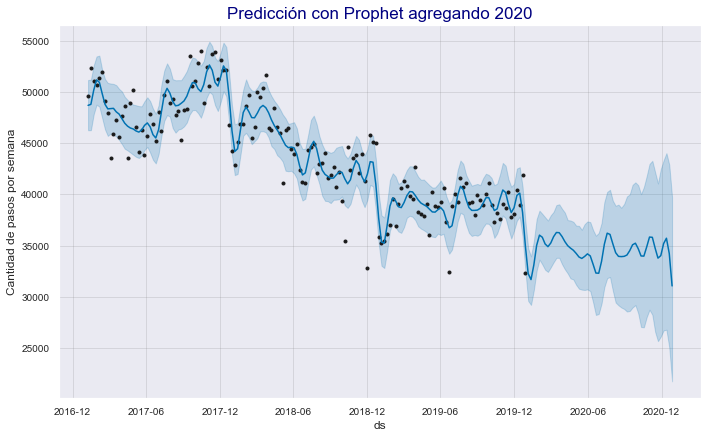

In [44]:
prophet_model_final = Prophet(changepoint_prior_scale = 0.3,
                              holidays_prior_scale= 0.3,
                              seasonality_mode = 'additive',
                              seasonality_prior_scale = 0.4,
                              weekly_seasonality=True,
                              daily_seasonality = True,
                              yearly_seasonality = True)

# De manera opcional se puede usar la siguiente línea de código para especificar los análisis de feriados
# prophet_model_final.add_country_holidays(country_name='AR')

prophet_model_final.fit(DS_prophet)

# Gráfica
future_model_final = prophet_model_final.make_future_dataframe(periods=52,freq='W')
forecast_model_final = prophet_model_final.predict(future_model_final)
fig1 = prophet_model_final.plot(forecast_model_final,ylabel='Cantidad de pasos por semana')
plt.title("Predicción con Prophet agregando 2020", color= 'navy', fontsize= 17);

Componentes del pronóstico de 2020

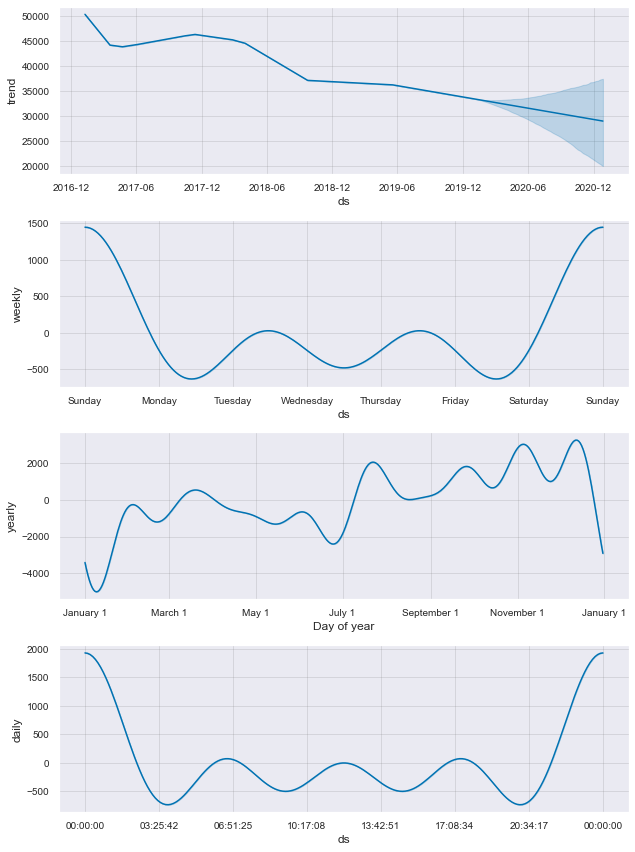

In [45]:
fig_2 = prophet_model_final.plot_components(forecast_model_final)

Comparativa de la serie original y el pronóstico para el año 2020

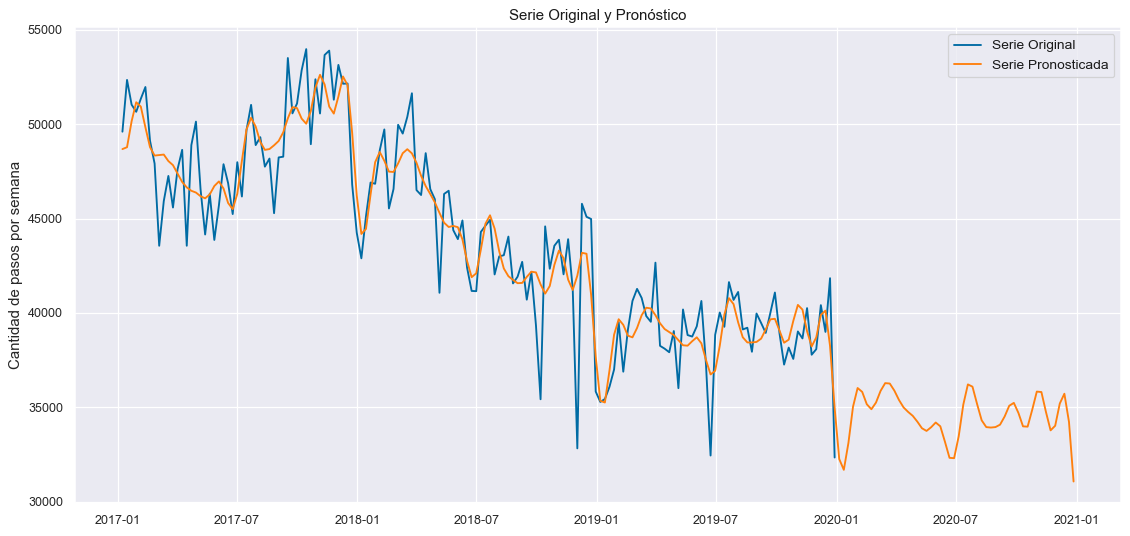

In [46]:
plt.figure(figsize = (15,7), dpi=90)
plt.plot(DS_prophet['ds'], DS_prophet['y'])
plt.plot(forecast_model_final['ds'], forecast_model_final['yhat'])
plt.title('Serie Original y Pronóstico')
plt.legend(['Serie Original','Serie Pronosticada'])
plt.ylabel('Cantidad de pasos por semana')
plt.show()

Algunas referencias consultadas para este notebook fueron:

- https://research.fb.com/prophet-forecasting-at-scale/
- https://docs.aws.amazon.com/es_es/forecast/latest/dg/aws-forecast-recipe-prophet.html
- https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
- https://topbigdata.es/prevision-de-la-serie-de-tiempo-con-el-profeta-en-python/
- https://ichi.pro/es/facebook-prophet-para-el-pronostico-de-series-de-tiempo-en-python-parte-1-239090574793501